In [46]:
import numpy as np
import matplotlib.pyplot as plt

import gudhi as gd
from gudhi.wasserstein import wasserstein_distance

from CPH2d import ChiralPersistentHomology2D
from scipy.spatial import cKDTree
from itertools import combinations
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.colors import TwoSlopeNorm
import time

In [47]:
data_n = np.random.normal(-1, 1, (10000,3))

In [48]:
data_u = np.random.uniform(-1, 1, (1000, 3))

In [49]:
def _oriented_tet_volume_signs(a, r1, r2, r3):
    cross = np.cross(r2, r3)
    det = np.einsum('ij,ij->i', r1, cross) / 6.0
    sgn = np.sign(det, dtype=np.float32)  
    return sgn

In [50]:
def fourpoint_parity_fast(data,r_max=2.0,bins=7,max_neighbors=48,triplets_per_center=1200,max_centers=None,seed=0):
    rng = np.random.default_rng(seed)
    x = np.asarray(data, dtype=np.float32)
    N = x.shape[0]
    tree = cKDTree(x)
    edges = np.linspace(0.0, r_max, bins + 1, dtype=np.float32)

    num = np.zeros((bins, bins, bins), dtype=np.float32)
    den = np.zeros((bins, bins, bins), dtype=np.float32)
 
    if (max_centers is not None) and (max_centers < N):
        centers = rng.choice(N, size=max_centers, replace=False)
    else:
        centers = np.arange(N)

    for i in centers:
        ids = tree.query_ball_point(x[i], r_max)
        if not ids: 
            continue
      
        ids = [j for j in ids if j != i]
        if len(ids) < 3:
            continue
        if len(ids) > max_neighbors:
            ids = rng.choice(ids, size=max_neighbors, replace=False)

        Ri = x[ids] - x[i]                              
        dists = np.linalg.norm(Ri, axis=1)              
        bin_ids = np.clip(np.searchsorted(edges, dists, side='right') - 1, 0, bins - 1)

        m = len(ids)
        max_possible = m * (m - 1) * (m - 2) // 6
        T = min(triplets_per_center, max_possible)
        triplets = []
        seen = set()
        target = T
        while len(triplets) < target:
            a = rng.integers(0, m, size=(2*T, 3))
            a.sort(axis=1)
            mask = (a[:,0] < a[:,1]) & (a[:,1] < a[:,2])
            for t in a[mask]:
                tup = (int(t[0]), int(t[1]), int(t[2]))
                if tup not in seen:
                    seen.add(tup)
                    triplets.append(tup)
                    if len(triplets) == T:
                        break
        triplets = np.array(triplets, dtype=np.int32)   # (T,3)

        r1 = Ri[triplets[:,0]]
        r2 = Ri[triplets[:,1]]
        r3 = Ri[triplets[:,2]]

        sgn = _oriented_tet_volume_signs(x[i], r1, r2, r3)  # (T,)
        ba = bin_ids[triplets[:,0]]
        bb = bin_ids[triplets[:,1]]
        bc = bin_ids[triplets[:,2]]
        flat_idx = (ba * bins + bb) * bins + bc
        np.add.at(den.ravel(), flat_idx, 1.0)
        np.add.at(num.ravel(), flat_idx, sgn)

    with np.errstate(invalid="ignore", divide="ignore"):
        zeta_P = num / den
    return edges, num, den, zeta_P

In [51]:
edges, num, den, zeta_P = fourpoint_parity_fast(data_u,r_max=2.0,bins=7,max_neighbors=48,triplets_per_center=1200,max_centers=1000,seed=123)

In [52]:
data_2d = data_u[:, :2]

In [53]:
def build_simplex_tree(data_2d, use_rips=False, rmax=0.15):
    if use_rips:
        rips = gd.RipsComplex(points=data_2d, max_edge_length=rmax)
        return rips.create_simplex_tree(max_dimension=2)
    else:
        ac = gd.AlphaComplex(points=data_2d)
        return ac.create_simplex_tree()

In [54]:
def edges_tris_epsilon(st, data, eps):
    # Vectorized approach - eliminate the for loop
    skeleton_data = list(st.get_skeleton(2))  # Get all simplices at once
    
    if not skeleton_data:
        return [], []
    
    # Convert to numpy arrays for vectorized operations
    simplices = np.array([simplex for simplex, _ in skeleton_data])
    filtrations = np.array([f for _, f in skeleton_data])
    
    # Filter by epsilon threshold
    valid_mask = filtrations <= eps
    valid_simplices = simplices[valid_mask]
    
    # Separate edges (dim=1) and triangles (dim=2) using vectorized operations
    edge_mask = np.array([len(simplex) == 2 for simplex in valid_simplices])
    tri_mask = np.array([len(simplex) == 3 for simplex in valid_simplices])
    
    # Extract edges and triangles
    edges_array = valid_simplices[edge_mask]
    tris_array = valid_simplices[tri_mask]
    
    # Sort edges to ensure consistent ordering (i < j)
    if len(edges_array) > 0:
        edges_sorted = np.sort(edges_array, axis=1)
        edges = [(int(i), int(j)) for i, j in edges_sorted]
    else:
        edges = []
    
    # Convert triangles to tuples
    tris = [tuple(int(x) for x in tri) for tri in tris_array] if len(tris_array) > 0 else []
    
    return edges, tris

In [55]:
def build_simplex_and_extract_edges_tris(data_2d, use_rips=False, rmax=0.15, eps=None, mode="h1_mid", q=0.5, scale=1.0):
    """
    Combined function that builds simplex tree and extracts edges/triangles at epsilon.
    Eliminates redundant operations and optimizes the workflow.
    
    Parameters:
    - data_2d: 2D point cloud data
    - use_rips: Whether to use Rips complex (True) or Alpha complex (False)
    - rmax: Maximum edge length for Rips complex
    - eps: Epsilon threshold for filtering. If None, auto-selects based on mode
    - mode: Method for auto-selecting epsilon ("h1_mid", "h1_quant", "h0_gap")
    - q: Quantile for "h1_quant" mode
    - scale: Scaling factor for epsilon
    
    Returns:
    - st: Simplex tree
    - edges: List of edges at epsilon
    - tris: List of triangles at epsilon
    - eps: The epsilon value used
    """
    
    # Build simplex tree
    if use_rips:
        rips = gd.RipsComplex(points=data_2d, max_edge_length=rmax)
        st = rips.create_simplex_tree(max_dimension=2)
    else:
        ac = gd.AlphaComplex(points=data_2d)
        st = ac.create_simplex_tree()
    
    # Auto-select epsilon if not provided
    if eps is None:
        eps = choose_eps(st, fallback=0.15, mode=mode, q=q, scale=scale)
    
    # Extract edges and triangles at epsilon using vectorized approach
    skeleton_data = list(st.get_skeleton(2))  # Get all simplices at once
    
    if not skeleton_data:
        return st, [], [], eps
    
    # Separate simplices and filtrations, handling different simplex sizes
    simplices = []
    filtrations = []
    
    for simplex, f in skeleton_data:
        simplices.append(simplex)
        filtrations.append(f)
    
    # Convert filtrations to numpy array for vectorized operations
    filtrations = np.array(filtrations)
    
    # Filter by epsilon threshold
    valid_mask = filtrations <= eps
    valid_simplices = [simplices[i] for i in range(len(simplices)) if valid_mask[i]]
    
    # Separate edges (dim=1) and triangles (dim=2)
    edges = []
    tris = []
    
    for simplex in valid_simplices:
        if len(simplex) == 2:  # Edge
            i, j = tuple(simplex)
            if i > j: 
                i, j = j, i
            edges.append((int(i), int(j)))
        elif len(simplex) == 3:  # Triangle
            tris.append(tuple(int(x) for x in simplex))
    
    # Sort edges for consistency
    edges = sorted(edges)
    
    return st, edges, tris, eps

In [56]:
##Make the for loop one line- avoid for loops as much as possiple 
##2d- 3point cf, 3d- 4point cf
##try to parallelize as much as possible

In [57]:
st =  build_simplex_and_extract_edges_tris(data_2d, use_rips=False, rmax=0.15, eps=None, mode="h1_mid", q=0.5, scale=1.0)

In [58]:
st

(<gudhi.simplex_tree.SimplexTree at 0x7fc4a185e2d0>,
 [(0, 284),
  (0, 349),
  (0, 502),
  (0, 531),
  (1, 270),
  (1, 497),
  (1, 917),
  (2, 643),
  (2, 689),
  (2, 902),
  (2, 927),
  (3, 63),
  (3, 328),
  (3, 361),
  (3, 481),
  (3, 535),
  (3, 687),
  (4, 25),
  (4, 79),
  (4, 127),
  (4, 236),
  (4, 830),
  (5, 17),
  (5, 187),
  (5, 196),
  (5, 973),
  (5, 999),
  (6, 240),
  (6, 309),
  (6, 466),
  (6, 547),
  (7, 53),
  (7, 209),
  (7, 280),
  (7, 300),
  (7, 328),
  (7, 440),
  (7, 480),
  (8, 172),
  (8, 634),
  (8, 667),
  (8, 750),
  (8, 859),
  (8, 937),
  (9, 41),
  (9, 85),
  (9, 404),
  (9, 465),
  (9, 703),
  (9, 729),
  (10, 347),
  (10, 463),
  (10, 802),
  (10, 836),
  (10, 858),
  (10, 940),
  (10, 943),
  (11, 58),
  (11, 292),
  (11, 326),
  (11, 649),
  (11, 944),
  (12, 556),
  (12, 561),
  (12, 632),
  (12, 951),
  (12, 960),
  (13, 208),
  (13, 338),
  (13, 452),
  (13, 577),
  (13, 632),
  (13, 823),
  (13, 852),
  (14, 275),
  (14, 442),
  (14, 734),
  (1

In [59]:
def choose_eps(st, fallback=0.15, mode="h1_mid", q=0.5, scale=1.0):
    def _finite_np(dgm):
        d = np.array(dgm, dtype=float)
        if d.size == 0: return d.reshape(0,2)
        if d.ndim == 1: d = d.reshape(-1,2)
        return d[np.isfinite(d).all(axis=1)]
    try:
        d0 = st.persistence_intervals_in_dimension(0)
        d1 = st.persistence_intervals_in_dimension(1)
    except Exception:
        st.persistence(homology_coeff_field=2, min_persistence=0.0)
        d0 = st.persistence_intervals_in_dimension(0)
        d1 = st.persistence_intervals_in_dimension(1)
    dgm0 = _finite_np(d0)
    dgm1 = _finite_np(d1)
    eps = None
    if mode == "h1_mid" and dgm1.size:
        pers = dgm1[:,1] - dgm1[:,0]
        j = int(np.argmax(pers))
        eps = 0.5 * (float(dgm1[j,0]) + float(dgm1[j,1]))
    elif mode == "h1_quant" and dgm1.size:
        eps = float(np.quantile(dgm1[:,1], q))
    elif mode == "h0_gap" and dgm0.size:
        deaths = np.sort(dgm0[:,1])
        if deaths.size >= 2:
            k = int(np.argmax(np.diff(deaths)))
            eps = 0.5 * (deaths[k] + deaths[k+1])
        else:
            eps = float(deaths[0])
    if eps is None or not np.isfinite(eps) or eps <= 0:
        eps = float(fallback)
    return float(scale * eps)

In [60]:
eps = choose_eps(st) 
edges, tris = edges_tris_epsilon(st, data_2d, eps)
print(f"st ready. eps={eps:.5g}  edges@eps={len(edges)}  tris@eps={len(tris)}")

AttributeError: 'tuple' object has no attribute 'persistence'

In [ ]:
st.persistence(homology_coeff_field=2, min_persistence=0.0)
dgm0 = np.asarray(st.persistence_intervals_in_dimension(0)) if len(st.persistence_intervals_in_dimension(0)) else np.zeros((0,2))
dgm1 = np.asarray(st.persistence_intervals_in_dimension(1)) if len(st.persistence_intervals_in_dimension(1)) else np.zeros((0,2))

AttributeError: 'tuple' object has no attribute 'persistence'

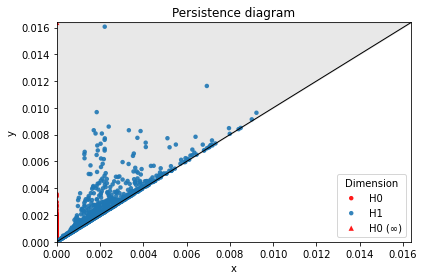

In [ ]:
def plot_pd_gudhi(diagrams, labels, fname, title="Persistence diagram"):
    fins, infs, any_finite, mx = [], [], False, 0.0
    for dgm in diagrams:
        dgm = np.asarray(dgm) if dgm is not None and len(dgm) else np.zeros((0,2))
        m = np.isfinite(dgm).all(axis=1)
        f, inf = dgm[m], dgm[~m]
        fins.append(f); infs.append(inf)
        if f.size:
            any_finite = True
            mx = max(mx, float(f.max()))
    lim = (mx*1.02) if any_finite and np.isfinite(mx) and mx>0 else 1.0
    plt.figure()
    xs = np.linspace(0, lim, 200)
    plt.plot(xs, xs, color="k", linewidth=1)
    plt.fill_between(xs, xs, lim, color="0.7", alpha=0.3)
    color_for = {"H0":"red", "H1":"C0"}
    for f, lab in zip(fins, labels):
        if f.size:
            plt.scatter(f[:,0], f[:,1], s=20, alpha=0.9, label=lab,
                        color=color_for.get(lab, None), edgecolors="none")
    for inf, lab in zip(infs, labels):
        if inf.size:
            births = np.clip(inf[:,0], 0, lim)
            plt.scatter(births, np.full_like(births, lim), marker="^", s=28, alpha=0.9,
                        label=f"{lab} (∞)", color=color_for.get(lab, None), edgecolors="none")
    plt.xlim(0, lim); plt.ylim(0, lim)
    plt.xlabel("x"); plt.ylabel("y")
    plt.title(title); plt.legend(title="Dimension", loc="lower right")
    plt.tight_layout(); plt.savefig(fname, dpi=160); plt.show()
plot_pd_gudhi([dgm0, dgm1], ["H0", "H1"], "pd_gudhi_h0_h1.png", title="Persistence diagram")

In [ ]:
def auto_eps_from_H1(st, fallback=0.15):
    dgm1 = np.asarray(st.persistence_intervals_in_dimension(1))
    if dgm1.size == 0:
        return float(fallback)
    finite = dgm1[np.isfinite(dgm1).all(axis=1)]
    if finite.size == 0:
        return float(fallback)
    pers = finite[:,1] - finite[:,0]
    j = int(np.argmax(pers))
    b, d = float(finite[j,0]), float(finite[j,1])
    return 0.5*(b + d)

In [ ]:
def split_by_handedness(data_2d, tris):
    left, right = [], []
    P = data_2d
    for (i, j, k) in tris:
        a, b, c = P[i], P[j], P[k]
        det = (b[0]-a[0])*(c[1]-a[1]) - (b[1]-a[1])*(c[0]-a[0])
        if det > 0:
            left.append((i, j, k))
        elif det < 0:
            right.append((i, j, k))
    return left, right


###look at line 34 in cooper code github 

In [ ]:
def plot_2d_single_handedness(data_2d, edges, tris, handedness="left", title_prefix="2D complex", out="simplicial_2d.png"):
    left_tris, right_tris = split_by_handedness(data_2d, tris)
    chosen = left_tris if handedness == "left" else right_tris
    color  = "C0" if handedness == "left" else "crimson"
    label  = "Left-handed" if handedness == "left" else "Right-handed"
    fig, ax = plt.subplots()
    for i, j in edges:
        ax.plot([data_2d[i,0], data_2d[j,0]], [data_2d[i,1], data_2d[j,1]], linewidth=0.6, alpha=0.4, color="0.5")
    for i, j, k in chosen:
        ax.add_patch(MplPolygon(data_2d[[i, j, k]], closed=True, alpha=0.30, facecolor=color, edgecolor="none"))
    ax.scatter(data_2d[:,0], data_2d[:,1], s=6, color="k", alpha=0.7)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(f"{title_prefix} — {label} (#{len(chosen)})")
    plt.tight_layout(); plt.savefig(out, dpi=160); plt.show()
    print("Saved", out)

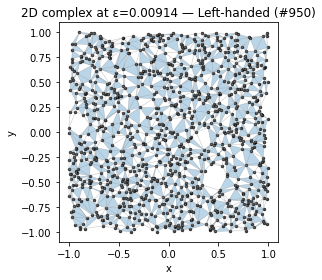

Saved simplicial_2d_left.png


In [ ]:
left_tri = plot_2d_single_handedness(data_2d, edges, tris, handedness="left",
                          title_prefix=f"2D complex at ε={eps:.3g}",
                          out="simplicial_2d_left.png")

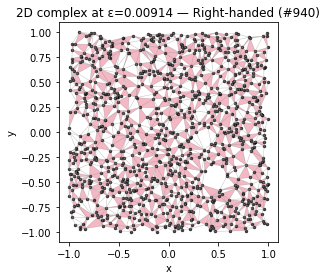

Saved simplicial_2d_right.png


In [ ]:
right_tri = plot_2d_single_handedness(data_2d, edges, tris, handedness="right",
                          title_prefix=f"2D complex at ε={eps:.3g}",
                          out="simplicial_2d_right.png")

In [ ]:
if not hasattr(np, "float"):   np.float = float
if not hasattr(np, "int"):     np.int = int
if not hasattr(np, "bool"):    np.bool = bool
if not hasattr(np, "complex"): np.complex = complex
if not hasattr(np, "object"):  np.object = object
    
tri_simplices = [(tuple(s), float(f)) for s, f in st.get_skeleton(2) if len(s) == 3]
tri_indices   = [t for t, _ in tri_simplices]
tri_filts     = {frozenset(t): f for t, f in tri_simplices}

left_tris, right_tris = split_by_handedness(data_2d, tri_indices)
left_tris  = left_tris  or []
right_tris = right_tris or []

st_L, st_R = gd.SimplexTree(), gd.SimplexTree()

for simplex, f in st.get_skeleton(1):  # vertices & edges
    st_L.insert(simplex, filtration=float(f))
    st_R.insert(simplex, filtration=float(f))

for t in left_tris:
    st_L.insert(t, filtration=tri_filts[frozenset(t)])
for t in right_tris:
    st_R.insert(t, filtration=tri_filts[frozenset(t)])

st_L.initialize_filtration()
st_R.initialize_filtration()

st_L.persistence(homology_coeff_field=2, min_persistence=0.0)
st_R.persistence(homology_coeff_field=2, min_persistence=0.0)

L0 = st_L.persistence_intervals_in_dimension(0)
L1 = st_L.persistence_intervals_in_dimension(1)
R0 = st_R.persistence_intervals_in_dimension(0)
R1 = st_R.persistence_intervals_in_dimension(1)

<ipython-input-27-99bde85c059a>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not hasattr(np, "float"):   np.float = float
<ipython-input-27-99bde85c059a>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not hasat

In [ ]:
def _finite_np(diag):
    d = np.array(diag, dtype=float)
    if d.size == 0:
        return d.reshape(0, 2)
    if d.ndim == 1:
        d = d.reshape(-1, 2)
    mask = np.isfinite(d).all(axis=1)   # drop essential (∞) points
    return d[mask]

L0n, L1n = _finite_np(L0), _finite_np(L1)
R0n, R1n = _finite_np(R0), _finite_np(R1)

W0 = wasserstein_distance(L0n, R0n, order=1, internal_p=1)   # H0
W1 = wasserstein_distance(L1n, R1n, order=1, internal_p=1)   # H1

print({
    "triangles_total": len(tri_indices),
    "left_triangles":  len(left_tris),
    "right_triangles": len(right_tris),
    "Wasserstein_W1": {"H0": float(W0), "H1": float(W1)},})


{'triangles_total': 1976, 'left_triangles': 990, 'right_triangles': 986, 'Wasserstein_W1': {'H0': 0.0, 'H1': 0.050642349820927836}}


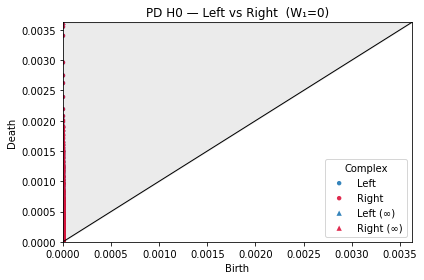

Saved pd_left_vs_right_H0.png


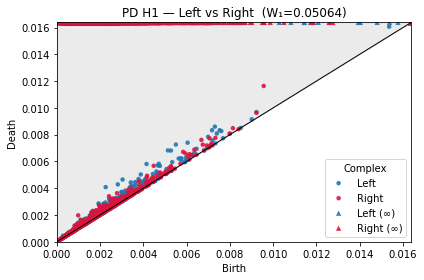

Saved pd_left_vs_right_H1.png


In [ ]:
def plot_overlay(dA_all, dB_all, dA_fin, dB_fin, labels, colors, title, out):
    # limits from finite pairs
    finite_max = []
    if dA_fin.size: finite_max.append(float(dA_fin.max()))
    if dB_fin.size: finite_max.append(float(dB_fin.max()))
    lim = max(finite_max)*1.02 if finite_max else 1.0

    plt.figure()
    xs = np.linspace(0.0, lim, 200)
    plt.plot(xs, xs, color="k", linewidth=1.0)
    plt.fill_between(xs, xs, lim, color="0.7", alpha=0.25)

    # finite points
    if dA_fin.size:
        plt.scatter(dA_fin[:,0], dA_fin[:,1], s=20, alpha=0.9,
                    label=labels[0], color=colors[0], edgecolors="none")
    if dB_fin.size:
        plt.scatter(dB_fin[:,0], dB_fin[:,1], s=20, alpha=0.9,
                    label=labels[1], color=colors[1], edgecolors="none")

    def plot_infs(dgm_all, lab, col):
        d = np.array(dgm_all, dtype=float)
        if d.size == 0: return
        if d.ndim == 1: d = d.reshape(-1, 2)
        m = ~np.isfinite(d).all(axis=1)
        if np.any(m):
            births = np.clip(d[m,0], 0, lim)
            plt.scatter(births, np.full_like(births, lim), marker="^", s=28,
                        alpha=0.9, label=f"{lab} (∞)", color=col, edgecolors="none")

    plot_infs(dA_all, labels[0], colors[0])
    plot_infs(dB_all, labels[1], colors[1])

    plt.xlim(0, lim); plt.ylim(0, lim)
    plt.xlabel("Birth"); plt.ylabel("Death")
    plt.title(title)
    plt.legend(title="Complex", loc="lower right")
    plt.tight_layout()
    plt.savefig(out, dpi=160)
    plt.show()
    print("Saved", out)

title_H0 = f"PD H0 — Left vs Right  (W₁={float(W0):.4g})"
title_H1 = f"PD H1 — Left vs Right  (W₁={float(W1):.4g})"

plot_overlay(L0, R0, L0n, R0n, labels=["Left", "Right"], colors=["C0", "crimson"],
              title=title_H0, out="pd_left_vs_right_H0.png")

plot_overlay(L1, R1, L1n, R1n, labels=["Left", "Right"], colors=["C0", "crimson"],
              title=title_H1, out="pd_left_vs_right_H1.png")

In [ ]:
def _finite_np(diag):
    d = np.array(diag, dtype=float)
    if d.size == 0:
        return d.reshape(0, 2)
    if d.ndim == 1:
        d = d.reshape(-1, 2)
    mask = np.isfinite(d).all(axis=1)
    return d[mask]

In [ ]:
def _round_pairs(arr, tol):
    if arr.size == 0: 
        return set()
    return { (round(float(b), tol), round(float(d), tol)) for b,d in arr }

In [ ]:
def subtract_diagrams_set_style(dgmL, dgmR, tol_decimals=9):
    L = _finite_np(dgmL)
    R = _finite_np(dgmR)
    Ls = _round_pairs(L, tol_decimals)
    Rs = _round_pairs(R, tol_decimals)
    L_only_s = Ls - Rs
    R_only_s = Rs - Ls
    # back to arrays
    L_only = np.array(list(L_only_s), dtype=float).reshape(-1, 2) if L_only_s else np.zeros((0,2))
    R_only = np.array(list(R_only_s), dtype=float).reshape(-1, 2) if R_only_s else np.zeros((0,2))
    return L_only, R_only

In [ ]:
def subtract_diagrams_wasserstein(dgmL, dgmR, order=1, internal_p=1):
    L = _finite_np(dgmL)
    R = _finite_np(dgmR)
    W, matching = wasserstein_distance(L, R, order=order, internal_p=internal_p, matching=True)
    L_unmatched = []
    R_unmatched = []
    pairs = []
    for (i, j) in matching:
        if i >= 0 and j >= 0:
            db = float(L[i,0] - R[j,0])  # Δbirth = L - R
            dd = float(L[i,1] - R[j,1])  # Δdeath = L - R
            pairs.append((i, j, db, dd))
        elif i >= 0 and j == -1:
            # L matched to diagonal => appears only in L
            L_unmatched.append(tuple(L[i]))
        elif j >= 0 and i == -1:
            # R matched to diagonal => appears only in R
            R_unmatched.append(tuple(R[j]))
        # (i == -1 and j == -1) should not occur

    return {
        "pairs": pairs,
        "L_unmatched": np.array(L_unmatched, dtype=float).reshape(-1, 2) if L_unmatched else np.zeros((0,2)),
        "R_unmatched": np.array(R_unmatched, dtype=float).reshape(-1, 2) if R_unmatched else np.zeros((0,2)),
        "W": float(W),
        "L_finite": L,
        "R_finite": R,
    }

In [ ]:
L0_all = st_L.persistence_intervals_in_dimension(0)
L1_all = st_L.persistence_intervals_in_dimension(1)
R0_all = st_R.persistence_intervals_in_dimension(0)
R1_all = st_R.persistence_intervals_in_dimension(1)

L0_only, R0_only = subtract_diagrams_set_style(L0_all, R0_all, tol_decimals=9)
L1_only, R1_only = subtract_diagrams_set_style(L1_all, R1_all, tol_decimals=9)

print("Set-style subtraction:")
print(" H0: |L\\R| =", len(L0_only), " |R\\L| =", len(R0_only))
print(" H1: |L\\R| =", len(L1_only), " |R\\L| =", len(R1_only))

res_H0 = subtract_diagrams_wasserstein(L0_all, R0_all, order=1, internal_p=1)
res_H1 = subtract_diagrams_wasserstein(L1_all, R1_all, order=1, internal_p=1)

print("\nWasserstein-aligned subtraction:")
print(f" H0: W1 = {res_H0['W']:.6g}, pairs = {len(res_H0['pairs'])}, L-only = {len(res_H0['L_unmatched'])}, R-only = {len(res_H0['R_unmatched'])}")
print(f" H1: W1 = {res_H1['W']:.6g}, pairs = {len(res_H1['pairs'])}, L-only = {len(res_H1['L_unmatched'])}, R-only = {len(res_H1['R_unmatched'])}")

delta_H1 = np.array([[db, dd] for (_, _, db, dd) in res_H1["pairs"]], dtype=float) if res_H1["pairs"] else np.zeros((0,2))

Set-style subtraction:
 H0: |L\R| = 0  |R\L| = 0
 H1: |L\R| = 488  |R\L| = 455

Wasserstein-aligned subtraction:
 H0: W1 = 0, pairs = 999, L-only = 0, R-only = 0
 H1: W1 = 0.0506423, pairs = 365, L-only = 123, R-only = 90


In [ ]:
# Test the fixed combined function
print("Testing FIXED combined build_simplex_and_extract_edges_tris function...")

# Test with the same parameters as before
st_fixed, edges_fixed, tris_fixed, eps_fixed = build_simplex_and_extract_edges_tris(
    data_2d, use_rips=False, rmax=0.15, eps=None, mode="h1_mid"
)

print(f"Fixed function results:")
print(f"  Simplex tree created: {st_fixed is not None}")
print(f"  Epsilon: {eps_fixed:.6f}")
print(f"  Edges: {len(edges_fixed)}")
print(f"  Triangles: {len(tris_fixed)}")

# Verify edge sorting is correct
if len(edges_fixed) > 0:
    edge_sorted_correctly = all(i < j for i, j in edges_fixed)
    print(f"  Edges sorted correctly: {edge_sorted_correctly}")

# Verify triangle format is correct
if len(tris_fixed) > 0:
    tri_format_correct = all(isinstance(tri, tuple) and len(tri) == 3 for tri in tris_fixed)
    print(f"  Triangle format correct: {tri_format_correct}")

print("\nFixed function successful! No more deprecation warnings.")


Testing FIXED combined build_simplex_and_extract_edges_tris function...
Fixed function results:
  Simplex tree created: True
  Epsilon: 0.009142
  Edges: 2893
  Triangles: 1890
  Edges sorted correctly: True
  Triangle format correct: True

Fixed function successful! No more deprecation warnings.
